In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn as nn
from torchvision import datasets,transforms
import torch.nn.functional as F
import sys
sys.path.append("../code/")
from dataloader import APPLIANCE_ORDER, get_train_test

/zf14/yj9xs/anaconda3/lib/python3.6/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [109]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=2, stride=(2, 1), padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=(2, 1), padding=1)
        self.bn5 = nn.BatchNorm2d(16)

        self.conv6 = nn.ConvTranspose2d(16, 1, kernel_size=(7, 7), stride=1, padding=2) 
        
        self.act = nn.ReLU()
        
    # forward method
    def forward(self, input):
        print(input.shape)
        e1 = self.conv1(input)
        bn1 = self.bn1(self.act(e1))
        print(bn1.shape)
        e2 = self.bn2(self.conv2(bn1))  
        print(e2.shape)
        e5 = self.bn5(self.conv5(e2))
        print(e5.shape)
        e6 = self.conv6(e5)
        print(e6.shape)
#         e5 = e6 = e2
        return e1, e2, e5, e6

In [110]:
class AppliancesCNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesCNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        self.layer1 = {}
        self.layer2 = {}
        self.layer3 = {}
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomCNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomCNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        else:
            pass
        for appliance in range(self.num_appliance):
            self.layer1[appliance], self.layer2[appliance], self.layer3[appliance], self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

In [111]:
torch.manual_seed(0)
num_folds = 5
dataset = 1
fold_num = 1
lr = 0.005
train, test = get_train_test(dataset, num_folds=num_folds, fold_num=fold_num)
# valid = train[int(0.8*len(train)):, :, :28].copy()
# train = train[:int(0.8 * len(train)), :, :28].copy()
# test = test[:, :, :28]

train_aggregate = train[:, 0, :, :].reshape(train.shape[0], 1, -1, 24)
valid_aggregate = valid[:, 0, :, :].reshape(valid.shape[0], 1, -1, 24)
test_aggregate = test[:, 0, :, :].reshape(test.shape[0], 1, -1, 24)

In [112]:
train_aggregate.shape

(54, 1, 112, 24)

In [113]:
# ORDER = ['hvac', 'dr', 'fridge', 'dw', 'mw']
ORDER = ['hvac', 'dr', 'fridge', 'dw', 'mw']
# ORDER = ['dw', 'mw', 'fridge', 'hvac', 'dr']
# ORDER = ['dr', 'hvac', 'fridge', 'mw', 'dw']
cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

In [114]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train.shape[0], 1, -1, 24))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_valid = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_valid[a_num] = Variable(
        torch.Tensor(valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((valid.shape[0], 1, -1, 24))))
    if cuda_av:
        out_valid[a_num] = out_valid[a_num].cuda()
        
out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test.shape[0], 1, -1, 24))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

In [115]:
loss_func = nn.L1Loss()
model = AppliancesCNN(len(ORDER))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if cuda_av:
    model = model.cuda()
    loss_func = loss_func.cuda()

In [116]:
inp = Variable(torch.Tensor(train_aggregate).type(torch.FloatTensor),
               requires_grad=True)

inp = Variable(torch.Tensor(train_aggregate), requires_grad=False)
if cuda_av:
    inp = inp.cuda()

valid_inp = Variable(torch.Tensor(valid_aggregate), requires_grad=False)
if cuda_av:
    valid_inp = valid_inp.cuda()

test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

valid_pred = {}
train_pred = {}
test_pred = {}
test_losses = {}
valid_losses = {}

valid_out = torch.cat([out_valid[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
test_out = torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
train_out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])

In [117]:
p = 0
num_iterations = 1400
params = [inp, p]
for a_num, appliance in enumerate(ORDER):
    params.append(out_train[a_num])
        
for t in range(1, num_iterations+1):
  
    if cuda_av:
        train_out = train_out.cuda()

    pred = model(*params)

    optimizer.zero_grad()
    loss = loss_func(pred, train_out)
    if t % 100 == 0:

        if cuda_av:
            valid_inp = valid_inp.cuda()
        valid_params = [valid_inp, -2]
        for i in range(len(ORDER)):
            valid_params.append(None)
        valid_pr = model(*valid_params)
        valid_loss = loss_func(valid_pr, valid_out)

        if cuda_av:
            test_inp = test_inp.cuda()
        test_params = [test_inp, -2]
        for i in range(len(ORDER)):
            test_params.append(None)
        test_pr = model(*test_params)
        test_loss = loss_func(test_pr, test_out)

        test_losses[t] = test_loss.data[0]
        valid_losses[t] = valid_loss.data[0]
        # np.save("./baseline/p_50_loss")

        if t % 1000 == 0:
            valid_pr = torch.clamp(valid_pr, min=0.)
            valid_pred[t] = valid_pr
            test_pr = torch.clamp(test_pr, min=0.)
            test_pred[t] = test_pr
            train_pr = pred
            train_pr = torch.clamp(train_pr, min=0.)
            train_pred[t] = train_pr

        print("Round:", t, "Training Error:", loss.data[0], "Validation Error:", valid_loss.data[0], "Test Error:", test_loss.data[0])

    loss.backward() 
    optimizer.step()



torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])


torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])


torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])


torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])


torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])


torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])
torch.Size([54, 1, 112, 24])
torch.Size([54, 1, 112, 24])
torch.Size([54, 16, 110, 22])
torch.Size([54, 32, 56, 23])
torch.Size([54, 16, 110, 22])


KeyboardInterrupt: 

In [80]:
sns.heatmap(pd.DataFrame(test_aggregate[home][0]), cmap=cmap, vmin=0, vmax=4500)

NameError: name 'sns' is not defined

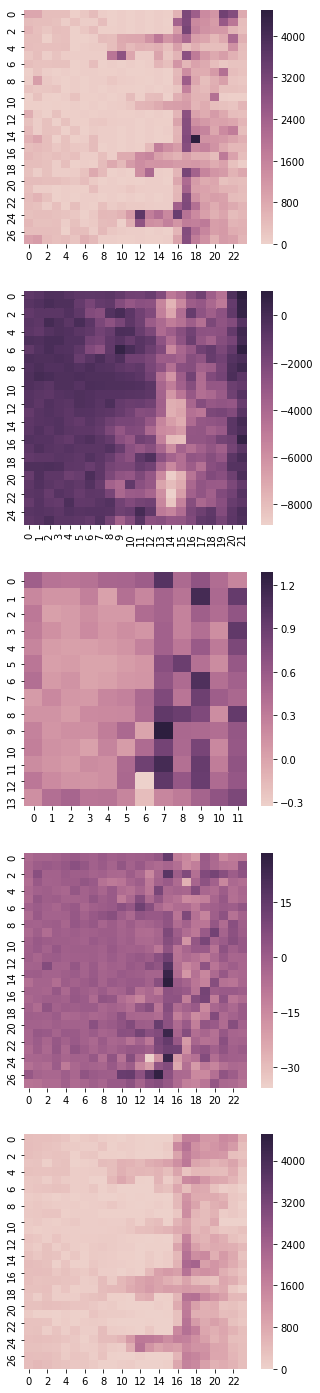

In [733]:
fig, axes = plt.subplots(ncols=1, nrows=5, figsize=(5, 25))
ax = axes.flatten()
cmap = sns.cubehelix_palette(as_cmap=True)

home = 0
sns.heatmap(pd.DataFrame(test_aggregate[home][0]), cmap=cmap, ax=ax[0], vmin=0, vmax=4500)
# for layer 1
layer1 = torch.split(model.layer1[0], train_aggregate.shape[0])
test = layer1[0].cpu().data.numpy()[home][3]
sns.heatmap(pd.DataFrame(test), cmap=cmap, ax=ax[1])
# for layer 2
layer2 = torch.split(model.layer2[0], train_aggregate.shape[0])
test = layer2[0].cpu().data.numpy()[home][7]
sns.heatmap(pd.DataFrame(test), cmap=cmap, ax=ax[2])
# for layer 3
layer3 = torch.split(model.layer3[0], train_aggregate.shape[0])
test = layer3[0].cpu().data.numpy()[home][1]
sns.heatmap(pd.DataFrame(test), cmap=cmap, ax=ax[3])
# prediction
# for layer 3
pred = torch.split(model.preds[0], train_aggregate.shape[0])
pred_1 = pred[0].cpu().data.numpy()[home][0]
sns.heatmap(pd.DataFrame(dr), cmap=cmap, ax=ax[4], vmin=0, vmax=4500)

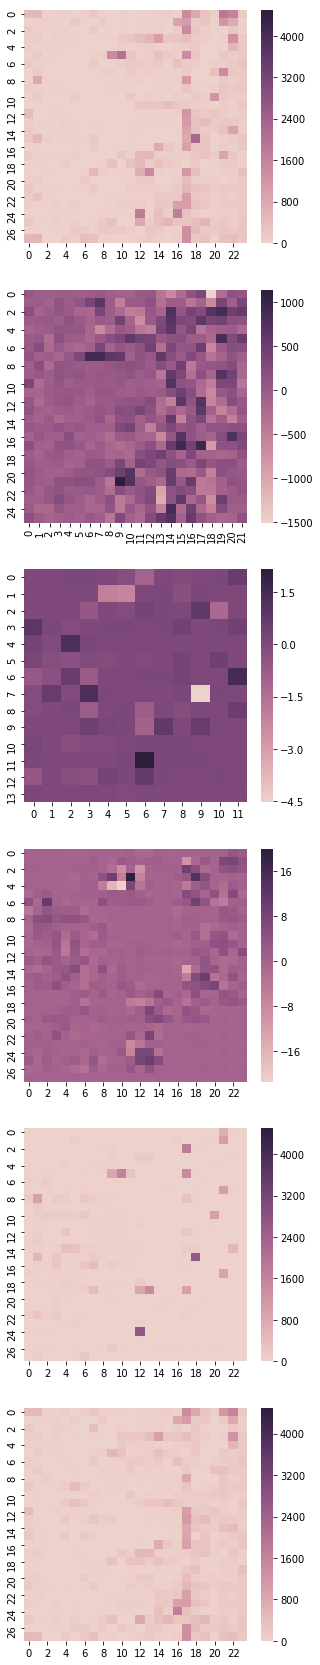

In [732]:
fig, axes = plt.subplots(ncols=1, nrows=6, figsize=(5, 30))
ax = axes.flatten()
cmap = sns.cubehelix_palette(as_cmap=True)

home = 0
sns.heatmap(pd.DataFrame(test_aggregate[home][0]-pred_1), cmap=cmap, ax=ax[0], vmin=0, vmax=4500)
# for layer 1
layer1 = torch.split(model.layer1[1], train_aggregate.shape[0])
test = layer1[0].cpu().data.numpy()[home][16]
sns.heatmap(pd.DataFrame(test), cmap=cmap, ax=ax[1])
# for layer 2
layer2 = torch.split(model.layer2[1], train_aggregate.shape[0])
test = layer2[0].cpu().data.numpy()[home][15]
sns.heatmap(pd.DataFrame(test), cmap=cmap, ax=ax[2])
# for layer 3
layer3 = torch.split(model.layer3[1], train_aggregate.shape[0])
test = layer3[0].cpu().data.numpy()[home][2]
sns.heatmap(pd.DataFrame(test), cmap=cmap, ax=ax[3])
# prediction
pred = torch.split(model.preds[1], train_aggregate.shape[0])
test = pred[0].cpu().data.numpy()[home][0]
sns.heatmap(pd.DataFrame(test), cmap=cmap, ax=ax[4], vmin=0, vmax=4500)

sns.heatmap(pd.DataFrame(test_aggregate[home][0]-pred_1-test), ax=ax[5], cmap=cmap, vmin=0, vmax=4500)

In [696]:
layer2[0].cpu().data.numpy()[home][0].shape

(14, 12)

In [644]:
model.modules()

<generator object Module.modules at 0x7f4b2b4c9888>

In [645]:
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        print(m)
        print(m.weight.cpu().data.numpy()[0, 0])

Conv2d (1, 20, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
[[-0.02106717  0.02835361 -0.03137976 -0.05092613  0.05110687 -1.07387626
  -0.79042608]
 [ 0.03154724 -0.10318359  0.07546162 -0.01391363  0.12087734 -0.60516405
  -0.07210172]
 [ 0.02295082 -0.00749144 -0.06685428  0.13494311  0.14013445 -0.95200342
  -0.24854441]
 [ 0.03476419  0.00611376  0.2236876   0.0610756  -0.68481362 -0.96744633
   0.05405798]
 [ 0.02154707 -0.00247564  0.06806567 -0.01458076  0.0611857  -0.57071513
  -0.870386  ]
 [ 0.03006456 -0.08824145  0.0717571   0.00616694  0.18242818 -0.11761997
   0.08482493]
 [-0.05624362  0.07611463 -0.19836365 -0.01038309 -0.00142635  0.177044
  -0.21975747]]
Conv2d (20, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
[[-0.01515354 -0.15952377]
 [ 0.14630662 -0.14770468]]
Conv2d (1, 20, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
[[-0.0500474  -0.05638938 -0.02327025 -0.09453113 -0.12865415 -0.03750887
  -0.08404798]
 [ 0.04060849 -0.10160466 -0.082472

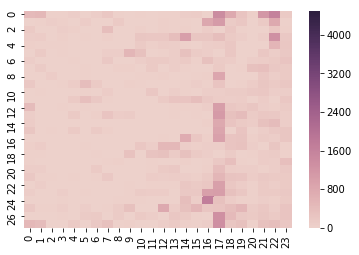

In [695]:
sns.heatmap(pd.DataFrame(test_aggregate[home][0]-pred_1-test), cmap=cmap, vmin=0, vmax=4500)

In [493]:
layer3 = torch.split(model.layer3[0], train_aggregate.shape[0])
layer3[0].cpu().data.numpy()[home][0]
# test = layer3[0].cpu().data.numpy().reshape(-1, 24)[home*112:(home+1)*112]

array([[  0.81970501,   1.00666702,  -4.25637674, ...,  -3.20281482,
        -11.5061121 ,   3.73340964],
       [  1.90745187,   0.28054246,  -3.61961484, ..., -11.41559315,
        -13.0335207 , -15.13350868],
       [ -0.35733417,  -0.77114195,  -5.07837296, ...,  -0.32554242,
         -0.9898864 ,  -3.50492287],
       ..., 
       [ -0.02923154,  -0.81488895,  -0.95766848, ...,  -9.8767395 ,
          9.60068417, -16.51737022],
       [  0.16878667,   1.43295455,   0.10438369, ...,  -9.13467026,
         10.7393055 ,  -1.50117671],
       [ -5.66758585,  -0.69620258,   0.6202023 , ...,   2.16575217,
         -3.07207942,  13.97320366]], dtype=float32)

In [372]:
from sklearn.metrics import mean_absolute_error

train_fold = {}
for t in range(1000, num_iterations + 1, 1000):
    train_pred[t] = torch.split(train_pred[t], train_aggregate.shape[0])
    train_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            train_fold[t][appliance_num] = train_pred[t][appliance_num].data.numpy().reshape(-1, 24)
            
valid_fold = {}
for t in range(1000, num_iterations + 1, 1000):

    valid_pred[t] = torch.split(valid_pred[t], valid_aggregate.shape[0])
    valid_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            valid_fold[t][appliance_num] = valid_pred[t][appliance_num].data.numpy().reshape(-1, 24)

test_fold = {}
for t in range(1000, num_iterations + 1, 1000):

    test_pred[t] = torch.split(test_pred[t], test_aggregate.shape[0])
    test_fold[t] = [None for x in range(len(ORDER))]
    if cuda_av:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].cpu().data.numpy().reshape(-1, 24)
    else:
        for appliance_num, appliance in enumerate(ORDER):
            test_fold[t][appliance_num] = test_pred[t][appliance_num].data.numpy().reshape(-1, 24)

# store ground truth of validation set
valid_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    valid_gt_fold[appliance_num] = valid[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        valid_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

test_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    test_gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        test_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

# calcualte the error of validation set
valid_error = {}
for t in range(1000, num_iterations + 1, 1000):
    valid_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        valid_error[t][appliance] = mean_absolute_error(valid_fold[t][appliance_num], valid_gt_fold[appliance_num])

test_error = {}
for t in range(1000, num_iterations + 1, 1000):
    test_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        test_error[t][appliance] = mean_absolute_error(test_fold[t][appliance_num], test_gt_fold[appliance_num])

In [373]:
train_gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    train_gt_fold[appliance_num] = train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(
        train_aggregate.shape[0],
        -1, 1).reshape(-1, 24)

In [374]:
train_error = {}
for t in range(1000, num_iterations + 1, 1000):
    train_error[t] = {}
    for appliance_num, appliance in enumerate(ORDER):
        train_error[t][appliance] = mean_absolute_error(train_fold[t][appliance_num], train_gt_fold[appliance_num])

In [375]:
pd.DataFrame(test_error)

,1000,2000
dr,59.199171,59.347006
dw,11.454806,11.551302
fridge,34.951982,35.531575
hvac,206.372862,206.258672
mw,9.987574,9.949834


In [441]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [277]:
test_aggregate.shape

(14, 1, 112, 24)

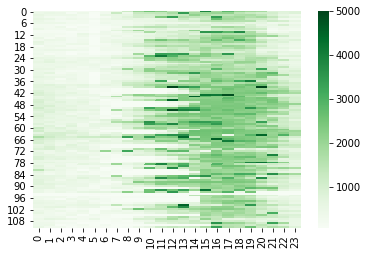

In [278]:
sns.heatmap(pd.DataFrame(test_aggregate[0][0]), cmap='Greens')

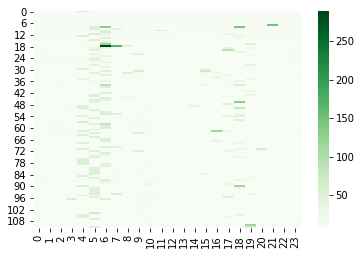

In [279]:
sns.heatmap(pd.DataFrame(test_gt_fold[4].reshape(-1, 112, 24)[5]), cmap='Greens')